## 이미지set
- https://www.kaggle.com/alxmamaev/flowers-recognition
- flowers image dataset
- 5개 중 imagenet에 있는 daisy, sunflower, tulip이용
- train 210(70*3), validation  60(20*3) ,test 60(20*3) (폴더로 분류한 채 이미지 사용)  

### zip 해제 : https://psychoria.tistory.com/330

### 깃허브: https://github.com/minji-o-j/Deep-Learning

# 1. Settings
## 1) Important reauired libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

#코랩에서 utils 불러오기
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils (4).py


In [2]:
## 코랩
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2) Hyperparameter

In [3]:
batch_size = 16
learning_rate = 0.0001
epoch = 20 

n_node = 1024 # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 #얼마나 드랍시킬 지 inverse keepratio

imgsize = 256

# 2. Data Loader
## 트레이닝 데이터

In [4]:
img_dir = '/content/gdrive/My Drive/Colab Notebooks/flowers/train'

train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2), #256256으로 중심크롭
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())
train_batch = data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=2)

210


## 고정된 데이터 셋

### validation set

In [5]:
#validation에서는 augmentation이 없다.
img_dir = '/content/gdrive/My Drive/Colab Notebooks/flowers/valid'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    ######################자동으로 이미지사이즈 조정해줌###################
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

print(dev_data.__len__())
dev_batch = data.DataLoader(dev_data, batch_size = batch_size, shuffle = True, num_workers=2)

60


In [6]:
##test
img_dir = '/content/gdrive/My Drive/Colab Notebooks/flowers/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

print(test_data.__len__())
test_batch = data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2)

60


In [7]:
nclass = len(train_data.classes)

print("number of classes : %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

number of classes : 3
['daisy', 'sunflower', 'tulip']
{'daisy': 0, 'sunflower': 1, 'tulip': 2}
210
Training: 210, Dev: 60, Test: 60


In [8]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['daisy', 'sunflower', 'tulip']
['daisy', 'sunflower', 'tulip']
['daisy', 'sunflower', 'tulip']


# 3. Model
## 1) Important reauired libraries

In [9]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [10]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## 2) Customized Fully Model

In [11]:
base_dim=64
fsize = imgsize/32

class MyVGG(nn.Module):#CNN
    def __init__(self):
        super(MyVGG, self).__init__()
        #[0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        ##뒷부분 (list(vgg.children())[-1])은 대체할거임
        self.layer1 = nn.Sequential(  
            nn.Linear(8 * base_dim * int(fsize) * int(fsize) , n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), #0.3만큼 드랍
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropratio),
            
            nn.Linear(n_node, nclass), #n_class: 클래스(폴더)개수
            
        )
        
        #weight initalization
        for m in self.layer1.modules() : #layer1만 학습해주면된다. (layer0은 내가 학습할 부분이 아님)
            #print(m)
            if isinstance(m, nn.Conv2d): ##fully connected에 convolution없지만 (복붙위해..?)
                init.kaiming_normal(m.weight.data) ##RELU일 때
                m.bias.data.fill_(0)
                
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)    
                
    def forward(self, x):
        # layer 0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x)
        #print(out.size())
        out = out.view(out.size(0),-1)
        out = self.layer1(out)
        return out

## 3) Model on GPU

In [12]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False ##학습안한다-> gradient 계산 안한다.

for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [13]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [14]:
loss_func = nn.CrossEntropyLoss()  ##분류모델
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate) ##layer 1만 학습하겠다 

```py
#layer을 두개 만들었을 때 (layer 1, layer 2)
import itertools
loss_func = nn.CrossEntropyLoss()  ##분류모델
optimizer = optim.Adam(itertools.chain(model.layer1.parameters(), model.layer2.parameters()), lr = learning_rate)
```

# 5. Train

In [18]:
import utils

total_time = 0
disp_step = 10

to_train = True #switch

if (to_train == False):#미리 트레인된게 있을때
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/flowers+vgg_10.pkl'
    model = torch.load(netname)
    
else : ##train한다.
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train()
    
    
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/flowers_vgg19'
    
    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면-->돌리다가 죽었을때 불러옴
    # netname = '../nets/flowers_vgg19.pkl'
    # model = torch.load(netname)
    
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
    #    params.required_grad = False
    # for params in model.layer1.parameters():
    #    params.required_grad = True
    # for i in range(34,epoch):


    # 재시작하지 않는다면, 학습하는 부분
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step ==0) or (i == epoch -1):
            torch.save(model, netname+'_%d.pkl'%i, ) ##중간중간에 저장한다!!!!!!!!!!!!1
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node : 1024, dropratio: 0.50
Correct of train: 81.43, dev: 77.14, test: 78.57
0..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[0/20] loss: 0.279,
Correct of train: 76.67, dev: 73.33, test: 73.33
time: 2.61 sec...
Total time: 2.61 sec
1..
Total time: 5.22 sec
2..
Total time: 7.84 sec
3..
Total time: 10.44 sec
4..
Total time: 13.07 sec
5..
Total time: 15.68 sec
6..
Total time: 18.29 sec
7..
Total time: 20.90 sec
8..
Total time: 23.52 sec
9..
Total time: 26.10 sec
10..

[10/20] loss: 0.275,
Correct of train: 80.00, dev: 93.33, test: 93.33
time: 28.70 sec...
Total time: 28.70 sec
11..
Total time: 31.30 sec
12..
Total time: 33.91 sec
13..
Total time: 36.53 sec
14..
Total time: 39.19 sec
15..
Total time: 41.77 sec
16..
Total time: 44.38 sec
17..
Total time: 46.98 sec
18..
Total time: 49.58 sec
19..

[19/20] loss: 2.466,
Correct of train: 91.43, dev: 95.00, test: 95.00
time: 52.19 sec...
Total time: 52.19 sec


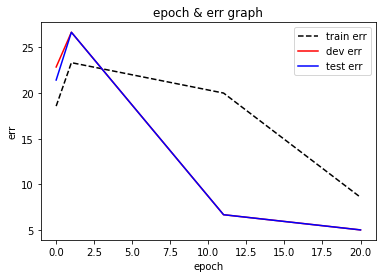

In [19]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label = 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

# 6. Evaluation for dev&test data

Normalized confusion matrix


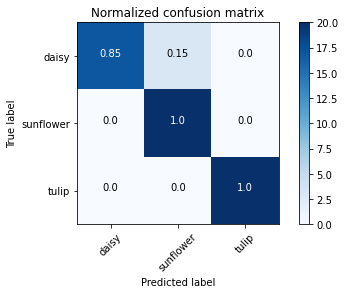

Confusion matrix, without normalization


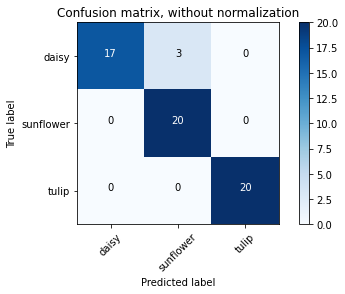

	 acc  |	 pre  |	 rec  |	 f1
 daisy: 0.95 |	 1.00 |	 0.85 |	 0.92
 sunflower: 0.95 |	 0.87 |	 1.00 |	 0.93
 tulip: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 0.97, precision: 0.96, recall: 0.95, *f1 score: 0.95
[AP]
daisy: 0.98
sunflower: 0.99
tulip: 1.00

[mAP] 0.990
[miAP] 0.972


(array([1, 1, 1, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 0, 2,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 2, 1, 1, 0,
        0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 1]),
 array([1, 1, 1, 2, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 0, 2,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0,
        0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 1]),
 array([0.97482783, 0.94152063, 0.58568174, 0.98652029, 0.9975965 ,
        0.79553157, 0.99740863, 0.983693  , 0.99515021, 0.99738801,
        0.77216101, 0.99967527, 0.99946171, 0.99450874, 0.77173591,
        0.99635905, 0.98886698, 0.98489475, 0.99966121, 0.99484003,
        0.94579512, 0.996234  , 0.96789354, 0.99604255, 0.93226236,
        0.56278396, 0.7692675 , 0.98077148, 0.99959832, 0.97553664,
        0.9993664 , 0.85779178, 0.7215941 , 0.98956329, 0.99841905,
        0.69876319, 0.98393524, 0.99659234, 0.99989837, 0.35137764,
        0.95271003, 0.93370807, 0.47587433, 

In [20]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

|class|acc|pre|rec|f1|
|---|---|---|---|---|
|daisy|0.95 |1.00 |0.85 |0.92 |
|sunflower|0.95|0.87 |1.00 |0.93|
|tulip|1.00|1.00|1.00|1.00 |


*accuracy: 0.97, precision: 0.96, recall: 0.95, *f1 score: 0.95


Category: daisy
 True predicted images/total daisy category: 17 / 20
Predicted probability:
[9.8369300e-01 1.5755875e-02 5.5111735e-04]


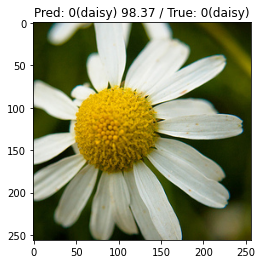

Predicted probability:
[0.8687902  0.10918446 0.0220253 ]


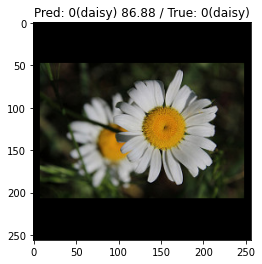

 False predicted images/total daisy category: 3 / 20
Predicted probability:
[0.06535229 0.7692675  0.16538022]


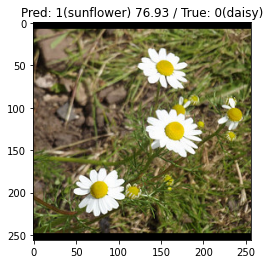

Predicted probability:
[0.26497796 0.47587398 0.25914803]


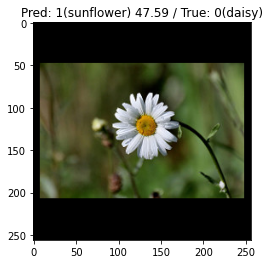

Category: sunflower
 True predicted images/total sunflower category: 20 / 20
Predicted probability:
[0.00280499 0.99484    0.00235501]


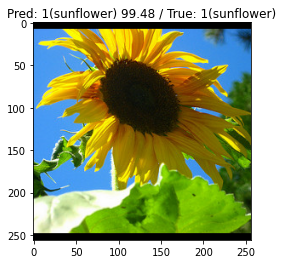

Predicted probability:
[0.02138038 0.9748278  0.00379178]


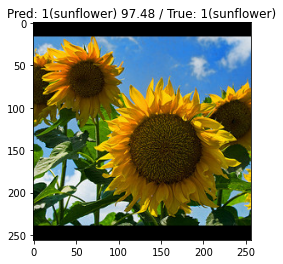

 False predicted images/total sunflower category: 0 / 20
Category: tulip
 True predicted images/total tulip category: 20 / 20
Predicted probability:
[0.00110912 0.00253181 0.99635905]


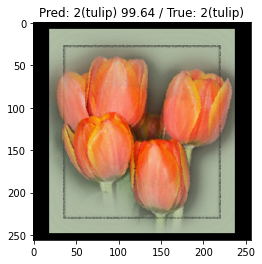

Predicted probability:
[9.0506690e-04 6.7585986e-04 9.9841905e-01]


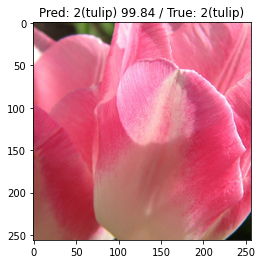

 False predicted images/total tulip category: 0 / 20


In [21]:
utils.VisTFPred(dev_batch, model,test_data.classes, batch_size, i_n=2)